In [2]:
import tensorflow as tf 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

## Plotando dados: TA x Spectral indices , TA X Spectral bands
### TA x (NDMI, MNDWI, PET) - I'll have to concatenate PET data

In [14]:
landsat_training_data = pd.read_csv('../Datasets/landsat_features_training.csv')
terra_climate_training_data = pd.read_csv('../Datasets/terraclimate_features_training.csv')
explained_variables = pd.read_csv('../Datasets/water_quality_training_dataset.csv')

joined_explaining_vars = combine_two_datasets(landsat_training_data, terra_climate_training_data)
full_dataset = combine_two_datasets(joined_explaining_vars, explained_variables)


full_dataset = scale_data_return_dataframe(full_dataset, ['Latitude', 'Longitude', 'Sample Date'])

ranges_information = [f'{column} , range: {full_dataset[column].min()} to {full_dataset[column].max()}' for column in full_dataset.columns.drop(['Latitude', 'Longitude', 'Sample Date']).values]
for information in ranges_information:
    print(information)

full_dataset.head()

nir , range: -3.4044478985043636 to 17.436079354853806
green , range: -2.137115347725475 to 19.992643153593054
swir16 , range: -2.9552062263179097 to 15.520508463868362
swir22 , range: -3.0578570449651608 to 7.761640705055673
NDMI , range: -4.48909380388289 to 7.016482041725595
MNDWI , range: -1.599951750669271 to 7.53016306187576
pet , range: -4.155860468861563 to 3.2453173594548543
Total Alkalinity , range: -1.5304642560980177 to 3.247722477262238
Electrical Conductance , range: -1.374254167921542 to 2.9860718223437113
Dissolved Reactive Phosphorus , range: -0.7557328056145404 to 2.971404721266379


,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI,pet,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-28.760833,17.730278,02-01-2011,-0.966963,0.519247,-1.756095,-1.483705,2.107580,3.480788,-0.032784,0.131262,0.204714,-0.657650
1,-26.861111,28.884722,03-01-2011,1.223488,-0.155910,0.053472,-0.334194,1.324806,-0.367333,-1.732917,-0.594310,-0.942047,2.343676
2,-26.450000,28.085833,03-01-2011,0.394344,0.265164,1.316047,1.089254,-1.343733,-1.111612,-1.617538,-0.399716,0.257358,0.715506
3,-27.671111,27.236944,03-01-2011,0.284965,0.345420,-0.013577,-0.008845,0.342453,0.397914,-1.542882,-0.496839,-0.823013,1.127452
4,-27.356667,27.286389,03-01-2011,0.942422,-0.173005,-0.269377,-0.699573,1.537679,0.016233,-1.559849,-0.843612,-0.994106,2.108278


## TA x NDMI

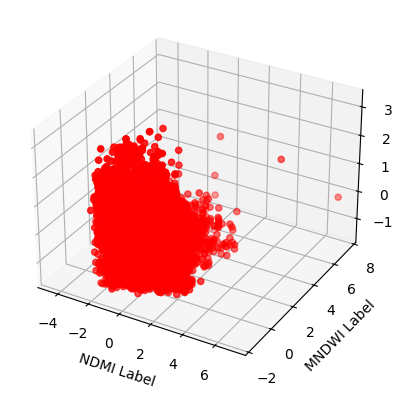

In [15]:
#making a 3d plot of NDMI and MNDWI (x, y) data in full_dataset against "Total Alkalinity" (z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_dataset['NDMI'], full_dataset['MNDWI'], full_dataset['Total Alkalinity'], c='r', marker='o')
ax.set_xlabel('NDMI Label')
ax.set_ylabel('MNDWI Label')
ax.set_zlabel('Total Alkalinity Label')
plt.show()

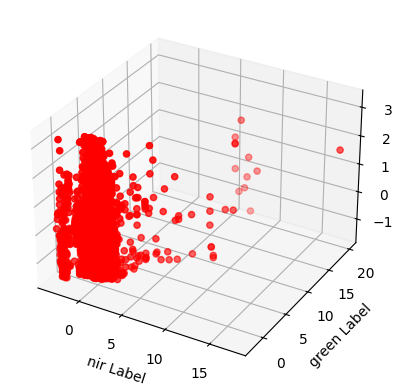

In [16]:
#making a 3d plot of nir and green (x, y) data in full_dataset against "Total Alkalinity" (z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_dataset['nir'], full_dataset['green'], full_dataset['Total Alkalinity'], c='r', marker='o')
ax.set_xlabel('nir Label')
ax.set_ylabel('green Label')
ax.set_zlabel('Total Alkalinity Label')
plt.show()

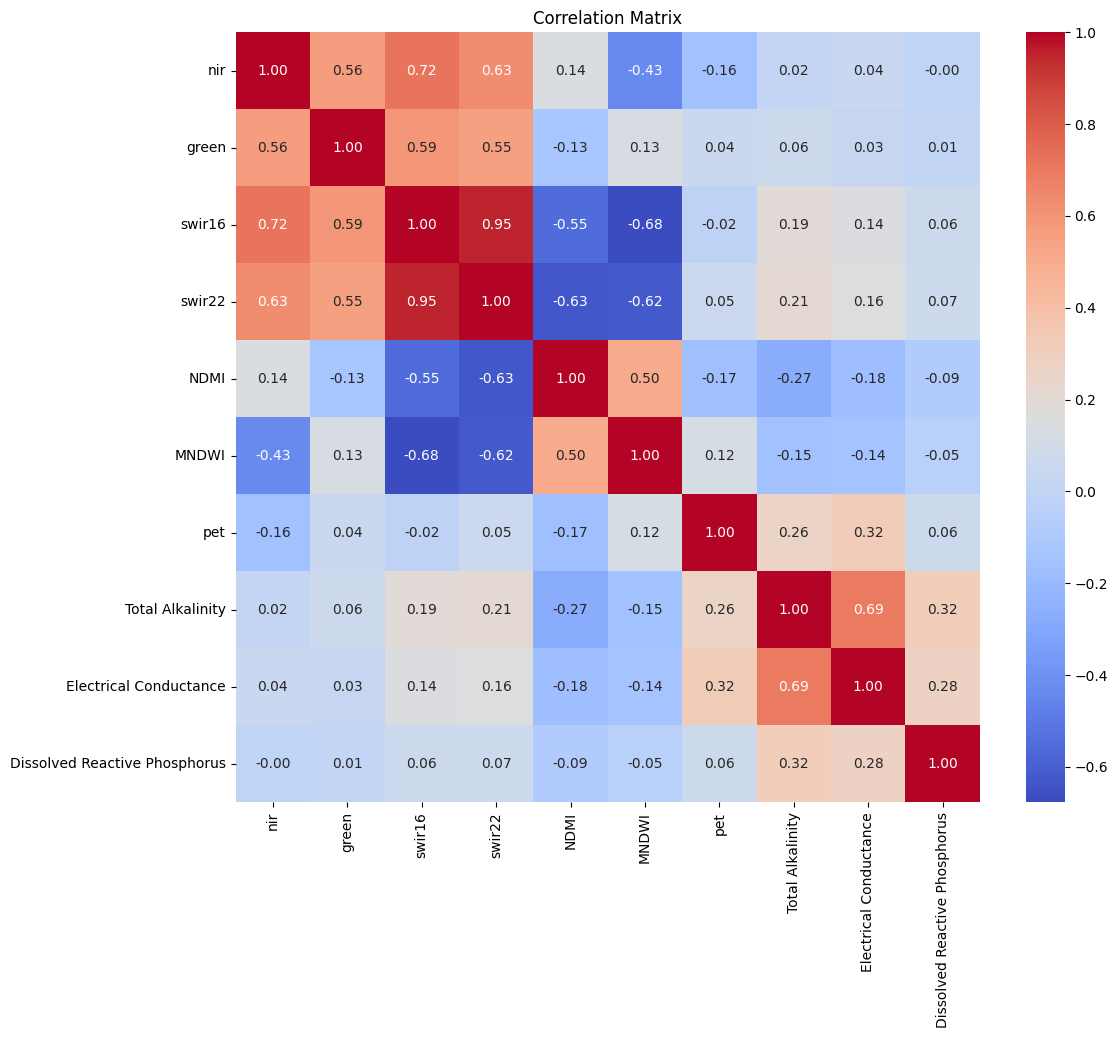

In [17]:
# plotting a correlation Matrix of all the data in full_dataset ( excluding "Latitude", "Longitude", "Sample Date")
correlation_matrix = full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### This Plot hihglights ONLY Linear Relationships, we'll plot those relationships and then we will see if there is any qadratic / cubic relationships between variables
### Ploting Strong Correlation variables, in linear analysis

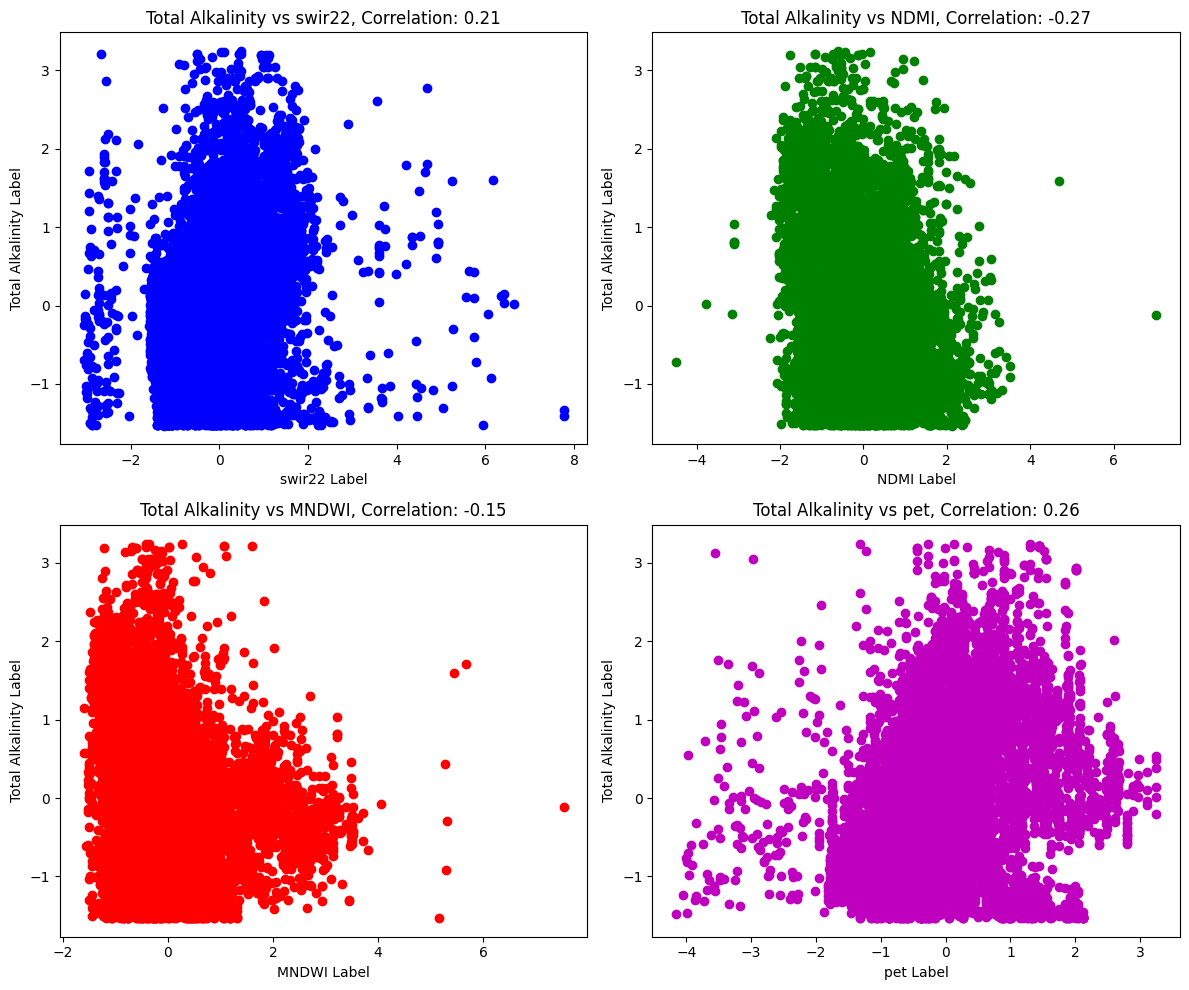

In [18]:
# making 4 plots: "Total Alkalinity" against "swir22", "NDMI", "MNDWI", "pet"
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(full_dataset['swir22'], full_dataset['Total Alkalinity'], c='b', marker='o')
axs[0, 0].set_xlabel('swir22 Label')
axs[0, 0].set_ylabel('Total Alkalinity Label')
axs[0, 0].set_title(f'Total Alkalinity vs swir22, Correlation: {correlation_matrix.loc["swir22", "Total Alkalinity"]:.2f}')
axs[0, 1].scatter(full_dataset['NDMI'], full_dataset['Total Alkalinity'], c='g', marker='o')
axs[0, 1].set_xlabel('NDMI Label')
axs[0, 1].set_ylabel('Total Alkalinity Label')
axs[0, 1].set_title(f'Total Alkalinity vs NDMI, Correlation: {correlation_matrix.loc["NDMI", "Total Alkalinity"]:.2f}')
axs[1, 0].scatter(full_dataset['MNDWI'], full_dataset['Total Alkalinity'], c='r', marker='o')
axs[1, 0].set_xlabel('MNDWI Label')
axs[1, 0].set_ylabel('Total Alkalinity Label')
axs[1, 0].set_title(f'Total Alkalinity vs MNDWI, Correlation: {correlation_matrix.loc["MNDWI", "Total Alkalinity"]:.2f}')
axs[1, 1].scatter(full_dataset['pet'], full_dataset['Total Alkalinity'], c='m', marker='o')
axs[1, 1].set_xlabel('pet Label')
axs[1, 1].set_ylabel('Total Alkalinity Label')
axs[1, 1].set_title(f'Total Alkalinity vs pet, Correlation: {correlation_matrix.loc["pet", "Total Alkalinity"]:.2f}')
plt.tight_layout()
plt.show()

### Adding quadratic data

In [19]:
quadradic_full_dataset = full_dataset.copy()
quadradic_full_dataset['swir22_squared'] = quadradic_full_dataset['swir22'] ** 2
quadradic_full_dataset['NDMI_squared'] = quadradic_full_dataset['NDMI'] ** 2
quadradic_full_dataset['MNDWI_squared'] = quadradic_full_dataset['MNDWI'] ** 2
quadradic_full_dataset['pet_squared'] = quadradic_full_dataset['pet'] ** 2
quadradic_full_dataset['nir_squared'] = quadradic_full_dataset['nir'] ** 2
quadradic_full_dataset['green_squared'] = quadradic_full_dataset['green'] ** 2
quadradic_full_dataset['swir16_squared'] = quadradic_full_dataset['swir16'] ** 2

quadradic_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)
quadradic_full_dataset.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,swir22_squared,NDMI_squared,MNDWI_squared,pet_squared,nir_squared,green_squared,swir16_squared
0,-28.760833,17.730278,02-01-2011,0.131262,0.204714,-0.657650,2.201381,4.441892,12.115884,0.001075,0.935018,0.269618,3.083871
1,-26.861111,28.884722,03-01-2011,-0.594310,-0.942047,2.343676,0.111685,1.755112,0.134934,3.003000,1.496923,0.024308,0.002859
2,-26.450000,28.085833,03-01-2011,-0.399716,0.257358,0.715506,1.186474,1.805619,1.235681,2.616430,0.155507,0.070312,1.731981
3,-27.671111,27.236944,03-01-2011,-0.496839,-0.823013,1.127452,0.000078,0.117274,0.158336,2.380484,0.081205,0.119315,0.000184
4,-27.356667,27.286389,03-01-2011,-0.843612,-0.994106,2.108278,0.489402,2.364457,0.000263,2.433130,0.888160,0.029931,0.072564


### Checking for quadratic relationships

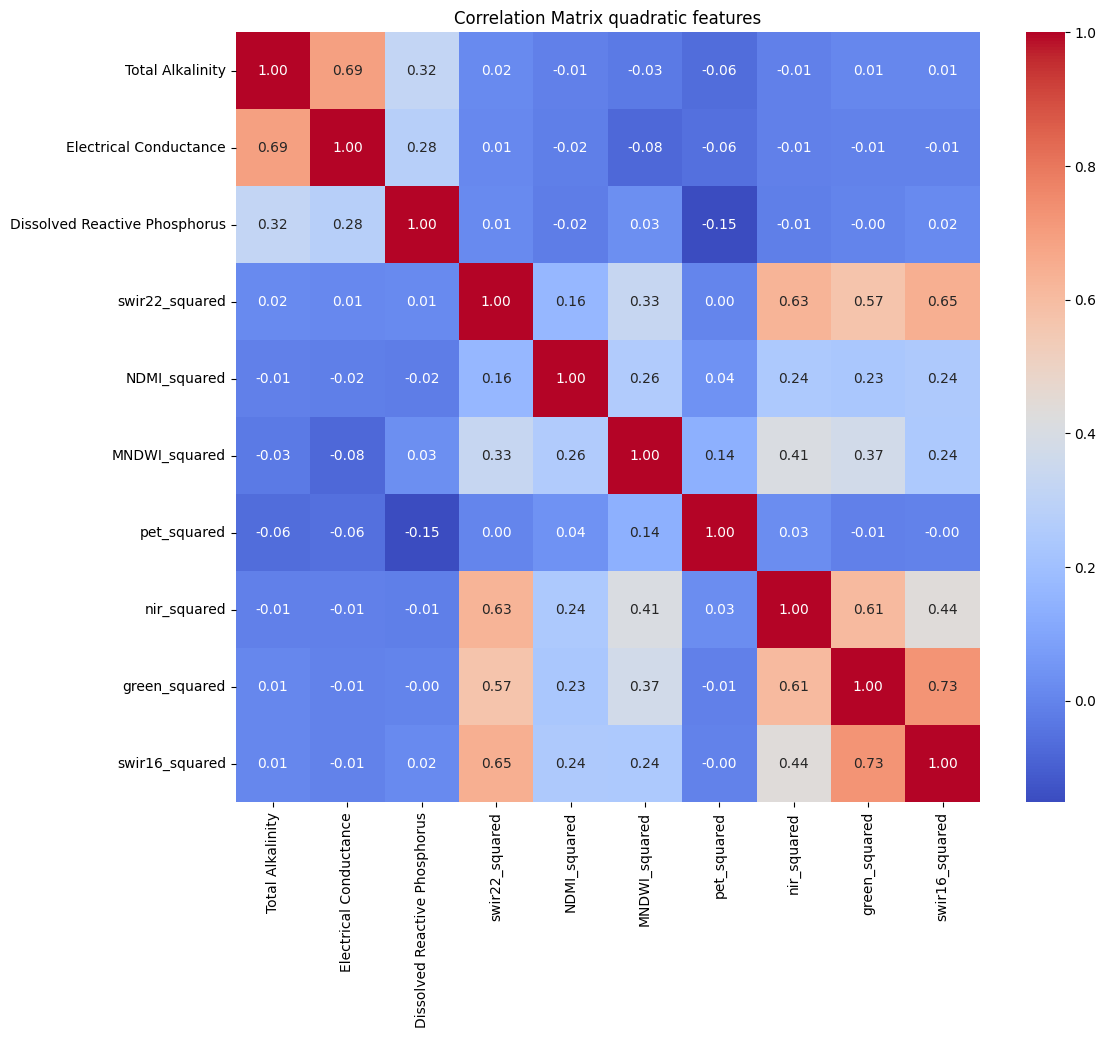

In [20]:
correlation_matrix = quadradic_full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix quadratic features')
plt.show()